# What do people want to learn about in data science?

In order to learn what the current popoular topics are in data science, we will be analyzing data from different stack exchange websites. 

## Questions allowed on these websites
* Specific issues within site's area of expertise
* Real problems or questions encountered

## Questions not allowed on the websites
* Opinion-based questions
* Too many possible answers to a question that requires an extremely long answer

## Information on Stack Exchange home page
* Questions (answered, active, bountied, and their popularity)
* Tags (popular, new)
* Users 

# Using StackExchange's data explorer
We can use StackExchange's query tool to find the data we need to answer the question of what people want to learn most about data science.

## Important Tables
Some of the important tables to inspect further include:
* Posts
* PostTags
* Tags
* TagSynonyms

The following SQL was used in the Stack Exchange Data Explorer to grab the Posts table.
```
SELECT Id, PostTypeId, CreationDate, Score, ViewCount, Tags, AnswerCount, 
        FavoriteCount
FROM Posts
WHERE PostTypeId = 1 AND YEAR(CreationDate) = 2019
ORDER BY CreationDate ASC
```

In [19]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
results = pd.read_csv('QueryResults.csv')
results.head(10)

,Id,PostTypeId,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,43363,1,2019-01-01 03:53:02,0,33,<machine-learning><nlp>,1,NaN
1,43366,1,2019-01-01 06:02:07,2,50,<deep-learning><convnet><image-classification>,1,1.0
2,43367,1,2019-01-01 06:16:26,0,24,<scikit-learn><tensorflow><scipy>,1,NaN
3,43370,1,2019-01-01 10:06:03,2,36,<classification>,0,NaN
4,43374,1,2019-01-01 13:18:02,3,36,<deep-learning><time-series><cnn><convolution>,1,NaN
5,43375,1,2019-01-01 13:24:28,2,146,<machine-learning><dataset><dimensionality-red...,1,NaN
6,43376,1,2019-01-01 14:19:59,4,1186,<machine-learning><python><xgboost>,1,1.0
7,43380,1,2019-01-01 19:15:29,1,117,<python><neural-network><keras><tensorflow>,1,NaN
8,43381,1,2019-01-01 19:16:04,1,258,<machine-learning><homework>,0,NaN
9,43385,1,2019-01-01 23:12:57,0,40,<optimization><theory>,1,NaN


# Analyzing the Data

From the data above, we can see that FavoriteCount has null values and the Tags column has multiple entries per row. We will have to fix these two problems and also check to make sure the datatypes of each column are accurate. 

## Fixing null values

The only column with null values is the FavoriteCount column, which tracks the number of times a question was favorited. We can fix this by making the null amounts equal to 0 to indicate no one favorited that question.

In [20]:
results.isnull().sum()

Id                  0
PostTypeId          0
CreationDate        0
Score               0
ViewCount           0
Tags                0
AnswerCount         0
FavoriteCount    6261
dtype: int64

In [21]:
results['FavoriteCount'] = results['FavoriteCount'].fillna(0)
results['FavoriteCount'].isnull().sum()

0

## Fixing incorrect data types
The CreationDate column should be a datetime object, but pandas reads it as only an object.  We will use to_datetime to convert it to a datetime object. We will also change favorite count to integers because there cannot be half of a favorite.

In [22]:
results.dtypes

Id                 int64
PostTypeId         int64
CreationDate      object
Score              int64
ViewCount          int64
Tags              object
AnswerCount        int64
FavoriteCount    float64
dtype: object

In [23]:
results['CreationDate'] = pd.to_datetime(results['CreationDate'])
results['FavoriteCount'] = results['FavoriteCount'].astype(int)
results.dtypes

Id                        int64
PostTypeId                int64
CreationDate     datetime64[ns]
Score                     int64
ViewCount                 int64
Tags                     object
AnswerCount               int64
FavoriteCount             int64
dtype: object

## Cleaning the Tags column
The Tags column currently lists the tags enclosed in the <> characters. We can clean the column and store the tags in a list to make it easier to loop over. 

In [24]:
results['Tags'] = results['Tags'].str.replace("^<|>$", "").str.split("><")
results.head(5)

,Id,PostTypeId,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,43363,1,2019-01-01 03:53:02,0,33,"[machine-learning, nlp]",1,0
1,43366,1,2019-01-01 06:02:07,2,50,"[deep-learning, convnet, image-classification]",1,1
2,43367,1,2019-01-01 06:16:26,0,24,"[scikit-learn, tensorflow, scipy]",1,0
3,43370,1,2019-01-01 10:06:03,2,36,[classification],0,0
4,43374,1,2019-01-01 13:18:02,3,36,"[deep-learning, time-series, cnn, convolution]",1,0


# Determining the Most Popular Tags
In order to determine the most popular tags, we're going to count how many times a tag was used and how many times a question with a tag was viewed. 

In [25]:
tag_freq = {}
post_tags = results['Tags']
for tags in post_tags:
    for tag in tags:
        if tag in tag_freq:
            tag_freq[tag] += 1
        else:
            tag_freq[tag] = 1

In [26]:
tag_freq = pd.DataFrame.from_dict(tag_freq, orient="index")
tag_freq.rename(columns={0: "Count"}, inplace=True)
most_used = tag_freq.sort_values(by=['Count'], ascending=False).head(20)

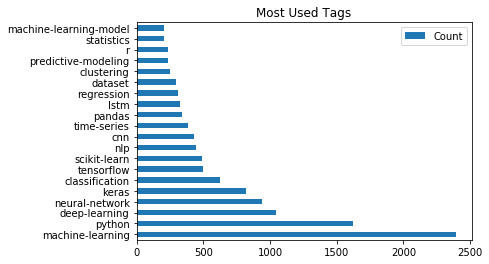

In [27]:
most_used.plot(kind="barh", title="Most Used Tags")

In [28]:
tag_views = {}
for index, row in results.iterrows():
    for tag in row["Tags"]:
        if tag in tag_views:
            tag_views[tag] += row["ViewCount"]
        else:
            tag_views[tag] = row["ViewCount"]

In [29]:
tag_views = pd.DataFrame.from_dict(tag_views, orient="index")
tag_views.rename(columns={0: "view_count"}, inplace=True)
most_viewed = tag_views.sort_values(by=['view_count'], ascending=False).head(20)

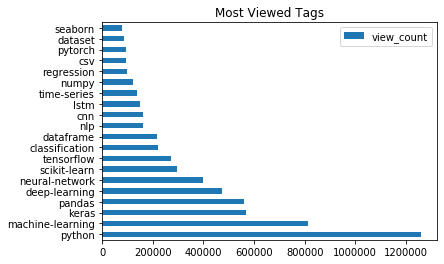

In [30]:
most_viewed.plot(kind="barh", title="Most Viewed Tags")

## Comparing most used vs most viewed tags

From the exploration below, we can see that tags present in most_used but not most_viewed are:
* clustering
* predictive-modeling
* r
* statistics
* machine-learning-model

The tags present in most_viewed but not most_used are:
* dataframe
* numpy
* csv
* pytorch
* seaborn

### Looking at tags present in most used but not most viewed

In [31]:
in_used = pd.merge(most_used, most_viewed, how="left", left_index=True, right_index=True)
in_used

,Count,view_count
machine-learning,2391,811288.0
python,1619,1259247.0
deep-learning,1048,475039.0
neural-network,939,397265.0
keras,822,569945.0
classification,622,220713.0
tensorflow,496,270403.0
scikit-learn,486,295420.0
nlp,441,160320.0
cnn,430,159726.0


### Looking at tags present in most viewed but not most used

In [33]:
in_viewed = pd.merge(most_used, most_viewed, how="right", left_index=True, right_index=True)
in_viewed

,Count,view_count
python,1619.0,1259247
machine-learning,2391.0,811288
keras,822.0,569945
pandas,336.0,559649
deep-learning,1048.0,475039
neural-network,939.0,397265
scikit-learn,486.0,295420
tensorflow,496.0,270403
classification,622.0,220713
dataframe,NaN,215407


# Analyzing All Data Science Questions
The most viewed and most used tags relate to deep learning using python, so we will be doing a deeper dive into all questions to determine if deep learning is just a trend. We will be looking at the last five years. 

Questions related to deep learning will most likely have the tags:
* deep-learning
* neural-network
* keras
* cnn
* scikit-learn
* tensorflow

In [37]:
deep_learning_tags = ['deep-learning', 'neural-network', 'keras', 'cnn', 'scikit-learn', 'tensorflow']

In [36]:
questions = pd.read_csv('questions.csv')
questions['Tags'] = questions['Tags'].str.replace("^<|>$", "").str.split("><")
questions.head(5)

,Id,CreationDate,Tags
0,55605,2019-07-13 05:19:34,"[reinforcement-learning, policy-gradients]"
1,55609,2019-07-13 08:32:56,"[neural-network, deep-learning, activation-fun..."
2,55611,2019-07-13 09:14:18,"[machine-learning, python, scikit-learn, recom..."
3,55613,2019-07-13 13:19:06,"[neural-network, regression, gradient-descent,..."
4,55616,2019-07-13 14:58:06,"[machine-learning, statistics]"


In order to determine which questions are related to deep learning, we have to see if they contain one of the deep learning tags.

In [ ]:
def class_deep_learning(tags):
    for tag in tags:
        if tag in deep_learning_tags:
            return 1
    return 0

In [39]:
questions['deep_learning'] = questions['Tags'].apply(class_deep_learning)
questions.head(5)

,Id,CreationDate,Tags,deep_learning
0,55605,2019-07-13 05:19:34,"[reinforcement-learning, policy-gradients]",0
1,55609,2019-07-13 08:32:56,"[neural-network, deep-learning, activation-fun...",1
2,55611,2019-07-13 09:14:18,"[machine-learning, python, scikit-learn, recom...",1
3,55613,2019-07-13 13:19:06,"[neural-network, regression, gradient-descent,...",1
4,55616,2019-07-13 14:58:06,"[machine-learning, statistics]",0


## Analyzing tag popularity over time

In order to make sure that the popularity of deep learning tags isn't just a temporary fad in the data science community, we'll look at how the deep learning tag use increased over the years.

In [41]:
questions['CreationDate'] = pd.to_datetime(questions['CreationDate'])
def fetch_quarter(datetime):
    year = str(datetime.year)[-2:]
    quarter = str(((datetime.month-1) // 3) + 1)
    return "{y}Q{q}".format(y=year, q=quarter)

questions["Quarter"] = questions["CreationDate"].apply(fetch_quarter)

In [45]:
questions.head(10)

,Id,CreationDate,Tags,deep_learning,Quarter
0,55605,2019-07-13 05:19:34,"[reinforcement-learning, policy-gradients]",0,19Q3
1,55609,2019-07-13 08:32:56,"[neural-network, deep-learning, activation-fun...",1,19Q3
2,55611,2019-07-13 09:14:18,"[machine-learning, python, scikit-learn, recom...",1,19Q3
3,55613,2019-07-13 13:19:06,"[neural-network, regression, gradient-descent,...",1,19Q3
4,55616,2019-07-13 14:58:06,"[machine-learning, statistics]",0,19Q3
5,55618,2019-07-13 17:12:30,"[nlp, pytorch, spacy, allennlp]",0,19Q3
6,55619,2019-07-13 17:40:07,"[nlp, natural-language-process]",0,19Q3
7,55625,2019-07-13 22:18:30,"[linear-regression, mse]",0,19Q3
8,55633,2019-07-14 08:00:34,"[machine-learning, classification, machine-lea...",0,19Q3
9,55635,2019-07-14 08:49:07,"[python, time-series]",0,19Q3


In [47]:
quarterly = questions.groupby('Quarter').agg({"deep_learning": ['sum', 'size']})
quarterly.columns = ['DeepLearningQuestions', 'TotalQuestions']
quarterly["DeepLearningRate"] = quarterly["DeepLearningQuestions"]\
                                /quarterly["TotalQuestions"]
# The following is done to help with visualizations later.
quarterly.reset_index(inplace=True)
quarterly.sample(5)

,Quarter,DeepLearningQuestions,TotalQuestions,DeepLearningRate
12,17Q2,225,645,0.348837
7,16Q1,110,516,0.213178
10,16Q4,177,527,0.335863
24,20Q2,908,2415,0.375983
25,20Q3,226,645,0.350388


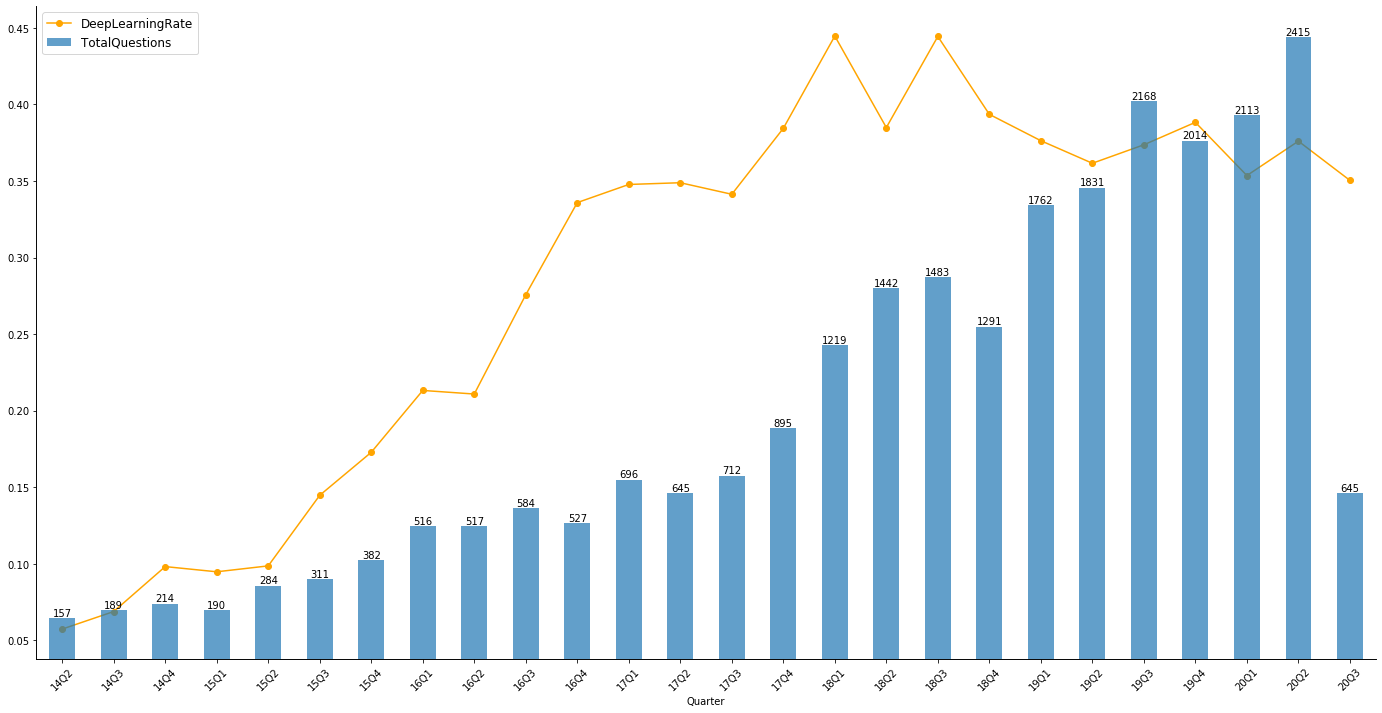

In [48]:
ax1 = quarterly.plot(x="Quarter", y="DeepLearningRate",
                    kind="line", linestyle="-", marker="o", color="orange",
                    figsize=(24,12)
                    )

ax2 = quarterly.plot(x="Quarter", y="TotalQuestions",
                     kind="bar", ax=ax1, secondary_y=True, alpha=0.7, rot=45)

for idx, t in quarterly["TotalQuestions"].iteritems():
    ax2.text(idx, t, str(t), ha="center", va="bottom")
xlims = ax1.get_xlim()

ax1.get_legend().remove()

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles=handles1 + handles2,
           labels=labels1 + labels2,
           loc="upper left", prop={"size": 12})


for ax in (ax1, ax2):
    for where in ("top", "right"):
        ax.spines[where].set_visible(False)
        ax.tick_params(right=False, labelright=False)

# Conclusion

According to the bar and line graph, the deep learning tags have been gradually increasing since 2017. Since 2020Q3 has not finished at the time of this analysis we would not expect the popularity to be as high as 2020Q2. It is reasonable to conclude that the deep learning topics of data science are among the most popular.